In [1]:
# %matplotlib nbagg
# %matplotlib notebook

import numpy as np
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors

%matplotlib inline

In [2]:
# Global variables.
NUM_LABELS = 2    # The number of labels.
BATCH_SIZE = 100  # The number of training examples to use per training step.

# data:     train eval
#   linear: 1000  200
#   moon:   2000  1000
#   saturn: 500   100
tf.app.flags.DEFINE_string('train', 'simdata/saturn_data_train.csv',
                           'File containing the training data (labels & features).')
tf.app.flags.DEFINE_string('test', 'simdata/saturn_data_eval.csv',
                           'File containing the test data (labels & features).')
tf.app.flags.DEFINE_integer('num_epochs', 20,
                            'Number of passes over the training data.')
tf.app.flags.DEFINE_integer('num_hidden', 100,
                            'Number of nodes in the hidden layer.')
tf.app.flags.DEFINE_boolean('verbose', True, 'Produce verbose output.')
tf.app.flags.DEFINE_boolean('plot', True, 'Plot the final decision boundary on the data.')

tf.app.flags.DEFINE_string('tfrecord_directory', 'tfrecords/',
                           'Folder to save tfrecord data (labels & features).')
tf.app.flags.DEFINE_string('train_valid_test_split', 'train',
                           'Differentiate train, valid and test data set.')

FLAGS = tf.app.flags.FLAGS

In [3]:
# Extract numpy representations of the labels and features given rows consisting of:
#   label, feat_0, feat_1, ..., feat_n
def extract_data(filename):

    # Arrays to hold the labels and feature vectors.
    labels = []
    fvecs = []

    # Iterate over the rows, splitting the label from the features. Convert labels
    # to integers and features to floats.
    for line in file(filename):     # file class has iterator property
        row = line.split(",")
        labels.append(int(row[0]))      # however the final output after net will be in float type
        fvecs.append([float(x) for x in row[1:]])

    # Convert the array of float arrays into a numpy float matrix.
    fvecs_np = np.array(fvecs).astype(np.float32)

    # Convert the array of int labels into a numpy array.
    labels_np = np.array(labels).astype(dtype=np.uint8)     # either 0 or 1

    # Convert the int numpy array into a one-hot matrix.
    labels_onehot = (np.arange(NUM_LABELS) == labels_np[:, None]).astype(np.float32)       # Boolean to Float number

    # Return a pair of the feature matrix and the one-hot label matrix.
    return fvecs_np, labels_onehot

In [4]:
# Init weights method. (Lifted from Delip Rao: http://deliprao.com/archives/100)
def init_weights(shape, init_method='xavier', xavier_params = (None, None)):
    if init_method == 'zeros':
        return tf.Variable(tf.zeros(shape, dtype=tf.float32))
    elif init_method == 'uniform':
        return tf.Variable(tf.random_normal(shape, stddev=0.01, dtype=tf.float32))
    else:   # xavier
        (fan_in, fan_out) = xavier_params
        low = -4*np.sqrt(6.0/(fan_in + fan_out))    # {sigmoid:4, tanh:1}
        high = 4*np.sqrt(6.0/(fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))

In [5]:
# for tfrecord writing
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
# _float_feature = lambda v: tf.train.Feature(float_list=tf.train.FloatList(value=v))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert_to_tfrecords(features, labels, filename):
    if features.shape[0] != labels.shape[0]:
        raise ValueError('Sample number does not match for feature and label')
    nb_examples = features.shape[0]
    filename = FLAGS.tfrecord_directory + filename + '.tfrecord'
    print('Writing {}'.format(filename))
    writer = tf.python_io.TFRecordWriter(filename)
    for index in range(nb_examples):
        example = tf.train.Example(features=tf.train.Features(feature={
            'feature/feature1': _float_feature(features[index, 0]),
            'feature/feature2': _float_feature(features[index, 1]),
            'label/label1': _float_feature(labels[index, 0]),
            'label/label2': _float_feature(labels[index, 1]),
#             'label': _float_feature(labels[index, :]),    # <class 'numbers.Real'> expected
        }))
        writer.write(example.SerializeToString())
    writer.close()

In [6]:
# for tfrecord reading
def read_from_tfrecords(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                      features = {
                                          'feature/feature1': tf.FixedLenFeature([], tf.float32),
                                          'feature/feature2': tf.FixedLenFeature([], tf.float32),
                                          'label/label1': tf.FixedLenFeature([], tf.float32),
                                          'label/label2': tf.FixedLenFeature([], tf.float32),
                                      })
    feature1_t = tf.cast(features['feature/feature1'], tf.float32)
    feature2_t = tf.cast(features['feature/feature2'], tf.float32)
    label1_t = tf.cast(features['label/label1'], tf.float32)
    label2_t = tf.cast(features['label/label2'], tf.float32)
    feature_t = tf.stack([feature1_t, feature2_t], 0)
    label_t = tf.stack([label1_t, label2_t], 0)
    return feature_t, label_t

In [7]:
def input_pipeline(filename):
    filename = FLAGS.tfrecord_directory + filename + '.tfrecord'
    with tf.name_scope('input'):
        # special case with a single file
        filename_queue = tf.train.string_input_producer([filename], FLAGS.num_epochs)
        feature_t, label_t = read_from_tfrecords(filename_queue)
        features, labels = tf.train.shuffle_batch([feature_t, label_t],
                                                 batch_size = BATCH_SIZE,
                                                 num_threads = 2,
                                                 capacity = 1000 + 3*BATCH_SIZE,
                                                 min_after_dequeue = 1000)
        return features, labels

In [8]:
# Be verbose?
verbose = FLAGS.verbose

# Plot? 
plot = FLAGS.plot

# Get the data.
train_data_filename = FLAGS.train
test_data_filename = FLAGS.test

# Extract it into numpy arrays.
train_data, train_labels = extract_data(train_data_filename)
test_data, test_labels = extract_data(test_data_filename)

# TODO save it to tfrecord format
filename_no_preext_train = FLAGS.train.split('.')[0].split('/')[-1]
filename_no_preext_test = FLAGS.test.split('.')[0].split('/')[-1]
convert_to_tfrecords(train_data, train_labels, filename_no_preext_train)
convert_to_tfrecords(test_data, test_labels, filename_no_preext_test)

# Get the shape of the training data.
train_size, num_features = train_data.shape

# Get the number of epochs for training.
num_epochs = FLAGS.num_epochs

# Get the size of layer one.
num_hidden = FLAGS.num_hidden

Writing tfrecords/saturn_data_train.tfrecord
Writing tfrecords/saturn_data_eval.tfrecord


In [9]:
def build_net(features, labels):
    # Initialize the hidden weights and biases.
    w_hidden = init_weights(
        [num_features, num_hidden],
        'xavier',
        xavier_params=(num_features, num_hidden))

    b_hidden = init_weights([1, num_hidden], 'zeros')

    # The hidden layer.
    hidden = tf.nn.tanh(tf.matmul(features, w_hidden) + b_hidden)

    # Initialize the output weights and biases.
    w_out = init_weights(
        [num_hidden, NUM_LABELS],
        'xavier',
        xavier_params=(num_hidden, NUM_LABELS))

    b_out = init_weights([1, NUM_LABELS], 'zeros')

    # The output layer.
    y = tf.nn.softmax(tf.matmul(hidden, w_out) + b_out)     # to be compared with y_

    # Optimization.
    cross_entropy = -tf.reduce_sum(labels*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

    # Evaluation.
    predicted_class = tf.argmax(y, 1);
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(labels,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    return cross_entropy, train_step, predicted_class, correct_prediction, accuracy

In [12]:
def plot_boundary_on_data(features, labels, pred_func):
    # determine canvas borders, in np.matrix
    mins = np.min(features, axis=0)         # np.min (which is just an alias for np.amin)
    mins -= 0.1 * np.abs(mins)
    maxs = np.amax(features, axis=0)
    maxs += 0.1 * maxs

    ## generate dense grid
    xs, ys = np.meshgrid(np.linspace(mins[0], maxs[0], 300),
                         np.linspace(mins[1], maxs[1], 300))
    
    nb_points_on_grid = xs.flatten().__len__()

    # evaluate model on the dense grid
    Z = []
    for i in range(nb_points_on_grid // BATCH_SIZE):
        Z.append(pred_func(np.c_[xs.flatten()[i*BATCH_SIZE:(i+1)*BATCH_SIZE], 
                                 ys.flatten()[i*BATCH_SIZE:(i+1)*BATCH_SIZE]]))
    Z = np.array(Z).reshape(xs.shape)

    # Plot the contour and training examples
    plt.contourf(xs, ys, Z, cmap=plt.cm.Spectral)   # draw contour lines and filled contours
    plt.scatter(features[:, 0], features[:, 1], c=labels[:,1], 
                s=50, cmap=colors.ListedColormap(['orange', 'blue']))

Accuracy @ step 005: 0.55000
Accuracy @ step 010: 0.50000
Accuracy @ step 015: 0.58000
Accuracy @ step 020: 0.72000
Accuracy @ step 025: 0.67000
Accuracy @ step 030: 0.59000
Accuracy @ step 035: 0.61000
Accuracy @ step 040: 0.54000
Accuracy @ step 045: 0.72000
Accuracy @ step 050: 0.77000
Accuracy @ step 055: 0.64000
Accuracy @ step 060: 0.56000
Accuracy @ step 065: 0.91000
Accuracy @ step 070: 0.90000
Accuracy @ step 075: 0.73000
Accuracy @ step 080: 0.96000
Accuracy @ step 085: 0.96000
Accuracy @ step 090: 0.86000
Accuracy @ step 095: 0.62000
Accuracy @ step 100: 0.98000
Done training for 20 epochs, 101 steps
Accuracy on test data: 0.87


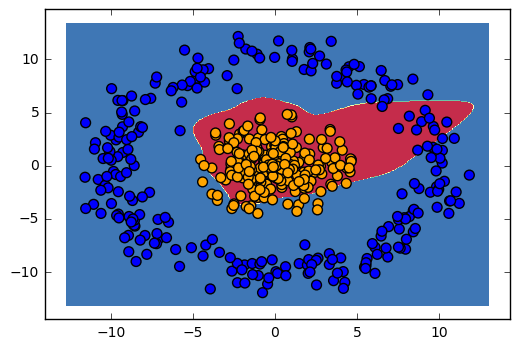

In [14]:
# with tf.Graph().as_default():    # can be skipped
# read from tfrecords
features, labels = input_pipeline(filename_no_preext_train)   # output the tensors
# prepare all optimization and evaluation tensors
cross_entropy, train_step, predicted_class, correct_prediction, accuracy = \
    build_net(features, labels)

with tf.Session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)

#     # debug
#     print [str(i.name) for i in tf.local_variables()]

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    try:
        step = 1
        while not coord.should_stop():
            _, loss_value, accuracy_value = sess.run([train_step, cross_entropy, accuracy])
            if verbose:
                if step % 5 == 0:
                    print 'Accuracy @ step {:03d}: {:.05f}'.format(step, accuracy_value)
            step += 1
    except tf.errors.OutOfRangeError:
        print('Done training for {} epochs, {} steps'.format(FLAGS.num_epochs, step))
    finally:
        coord.request_stop()

    coord.join(threads)

    # test_data co-incidently has shape of (BATCH_SIZE, 2)
    print "Accuracy on test data:", accuracy.eval(feed_dict={features: test_data, labels: test_labels})

    if plot:
        eval_fun = lambda X: predicted_class.eval(feed_dict={features: X})
#         plot_boundary_on_data(test_data, test_labels, eval_fun)
        plot_boundary_on_data(train_data, train_labels, eval_fun)